In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from matplotlib.animation import FuncAnimation
%matplotlib ipympl

In [2]:
#let pytorch use the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# print the device
print(device)

cuda:0


In [3]:
# create a fully connected neural network with 1 input 3 hidden layer with 30 nodes and one output node

class FNN(nn.Module):
    def __init__(self, layer_sizes):
        """
        Create a fully connected neural network with any number of layers.

        Args:
        - layer_sizes (list of int): Sizes of each layer, including input and output.
                                      For example, [2, 4, 3, 1] creates:
                                      Input (2) -> Hidden (4) -> Hidden (3) -> Output (1).
        """
        super(FNN, self).__init__()
        self.layers = nn.ModuleList()

        # Dynamically create layers
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

        # self.activation = nn.ReLU()  # Use ReLU as the activation function
        self.activation = nn.Tanh()  # Use Tanh as the activation function

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:  # Apply activation to all except the last layer
                x = self.activation(x)
        return x


torch.Size([19, 1])
torch.Size([19, 1])


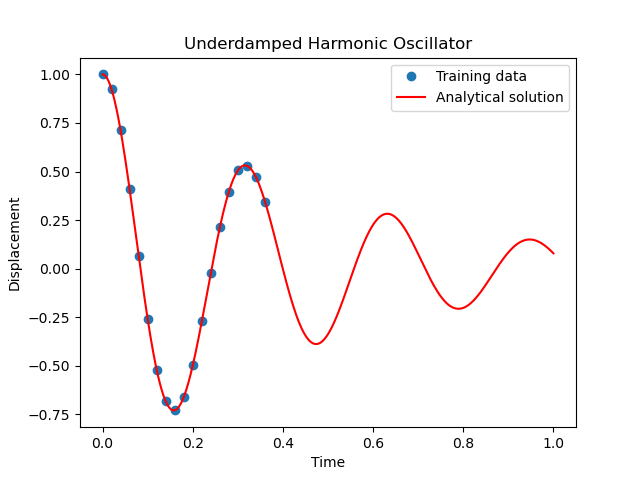

In [4]:
def SHM(d, w0, t):
    """Analytical solution to the 1D underdamped SHM. """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    sin = torch.sin(phi+w*t)
    exp = torch.exp(-d*t)
    y  = exp*2*A*cos
    return y


# create a plot of the oscillator
omega0 = 20
d = 2

t = torch.linspace(0, 1, 1000).view(-1, 1)#.to(device)
y = SHM(d, omega0, t).view(-1,1)#.to(device)

#select training data
ydata = y[0:380:20]
tdata = t[0:380:20]
print(tdata.shape)
print(ydata.shape)
plt.plot(tdata.cpu().numpy(), ydata.cpu().numpy(), 'o', label='Training data')
plt.plot(t.cpu().numpy(), y.cpu().numpy(), label='Analytical solution', color='red')
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.title("Underdamped Harmonic Oscillator")
plt.legend()
plt.show()

In [5]:
torch.manual_seed(40)
# Create a neural network with 1 input, 3 hidden layers with 30 nodes, and 1 output

model = FNN([1, 30, 30, 30, 1])#.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

FNN(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=30, bias=True)
    (1-2): 2 x Linear(in_features=30, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=1, bias=True)
  )
  (activation): Tanh()
)


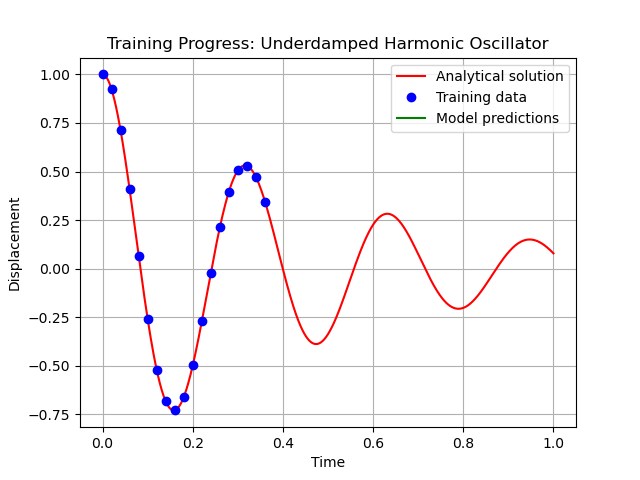

In [6]:

# Prepare the plot
fig, ax = plt.subplots()
ax.set_title("Training Progress: Underdamped Harmonic Oscillator")
ax.set_xlabel("Time")
ax.set_ylabel("Displacement")
ax.grid()

# Plot the analytical solution (red line, static)
ax.plot(t.cpu().numpy(), y.cpu().numpy(), label="Analytical solution", color="red")

# Initialize the scatter plot for training data (blue points) and line plot for predictions (green line)
scatter = ax.plot(tdata.cpu().numpy(), ydata.cpu().numpy(), 'o', label="Training data", color='blue')[0]
line, = ax.plot([], [], label="Model predictions", color="green")

ax.legend()

# Function to update the plot for each epoch
def update(epoch):
    global model, optimizer  # Use the global model and optimizer

    # Perform a training step
    optimizer.zero_grad()
    y_pred = model(tdata)
    loss = torch.nn.MSELoss()(y_pred, ydata)
    loss.backward()
    optimizer.step()

    # Compute predictions for the full `t` range
    yh = model(t)

    # Update the green line (model predictions)
    line.set_data(t.cpu().numpy(), yh.cpu().detach().numpy())

    # Update the title to show the current epoch
    ax.set_title(f"Training Progress: Epoch {epoch}")

    # Optionally, print loss for each epoch
    # print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return line, scatter

# Number of epochs for training
num_epochs = 3000

# Create animation
ani = FuncAnimation(fig, update, frames=range(num_epochs), blit=False, interval=50, repeat=False)

# Display the animat ion
plt.show()


### Adding physics loss

In [7]:
# tphy = tdata.requires_grad_(True)#.to(device)
tphy = torch.linspace(0, 1, 40).view(-1, 1).requires_grad_(True)#.to(device)

In [8]:
torch.manual_seed(40)
# Create a neural network with 1 input, 3 hidden layers with 30 nodes, and 1 output

model = FNN([1, 30, 30, 30, 1])#.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

FNN(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=30, bias=True)
    (1-2): 2 x Linear(in_features=30, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=1, bias=True)
  )
  (activation): Tanh()
)


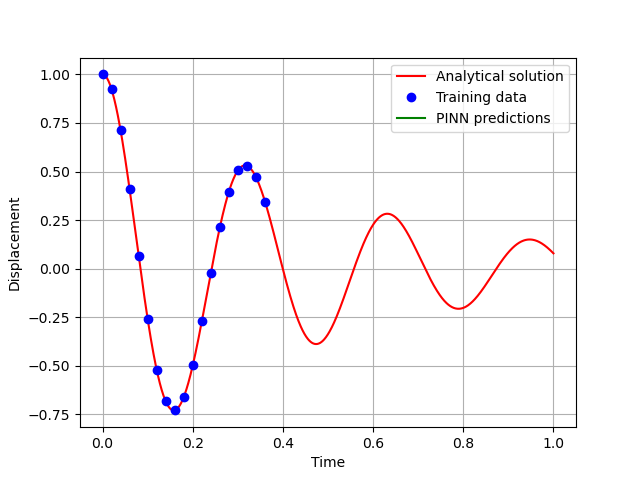

In [9]:


# Prepare the plot
fig, ax = plt.subplots()
ax.set_xlabel("Time")
ax.set_ylabel("Displacement")
ax.grid()

# Plot the analytical solution (red line, static)
ax.plot(t.cpu().numpy(), y.cpu().numpy(), label="Analytical solution", color="red")

# Initialize the scatter plot for training data (blue points) and line plot for predictions (green line)
scatter = ax.plot(tdata.cpu().detach().numpy(), ydata.cpu().numpy(), 'o', label="Training data", color='blue')[0]
line, = ax.plot([], [], label="PINN predictions", color="green")

ax.legend()

# Function to update the plot for each epoch
def update(epoch):
    global model, optimizer  # Use the global model and optimizer

    # Perform a training step
    optimizer.zero_grad()
    y_pred = model(tdata)

    # data loss
    loss1 = torch.nn.MSELoss()(y_pred, ydata)

    # physics loss
    yphy = model(tphy)
    dydt = torch.autograd.grad(yphy, tphy, torch.ones_like(yphy), create_graph=True)[0] # First derivative
    d2ydt2 = torch.autograd.grad(dydt, tphy, torch.ones_like(dydt), create_graph=True)[0] # Second derivative
    loss2 = 1e-5*(torch.mean((d2ydt2 + 2*d*dydt + omega0**2*yphy)**2))
    # print(loss1, loss2)
    # print(loss1, loss2)
    loss = loss1 + loss2
    

    loss.backward()
    optimizer.step()

    # Compute predictions for the full `t` range
    yph = model(t)

    # Update the green line (model predictions)
    line.set_data(t.cpu().numpy(), yph.cpu().detach().numpy())

    # Update the title to show the current epoch
    ax.set_title(f"Training Progress: Epoch {epoch}")

    # Optionally, print loss for each epoch
    # print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return line, scatter

# Number of epochs for training
num_epochs = 3000

# Create animation
ani = FuncAnimation(fig, update, frames=range(num_epochs), blit=False, interval=50, repeat=False)

# Display the animation
plt.show()
